In [2]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Cast images and masks to float32
            X = X.astype(np.float32)
            Y = Y.astype(np.float32)
            
            yield (X,Y)    

            batch_start += batch_size   
            batch_end += batch_size


In [3]:
from matplotlib import pyplot as plt
import random

train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

In [3]:
#verfying
img, msk = train_img_datagen.__next__()


In [4]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

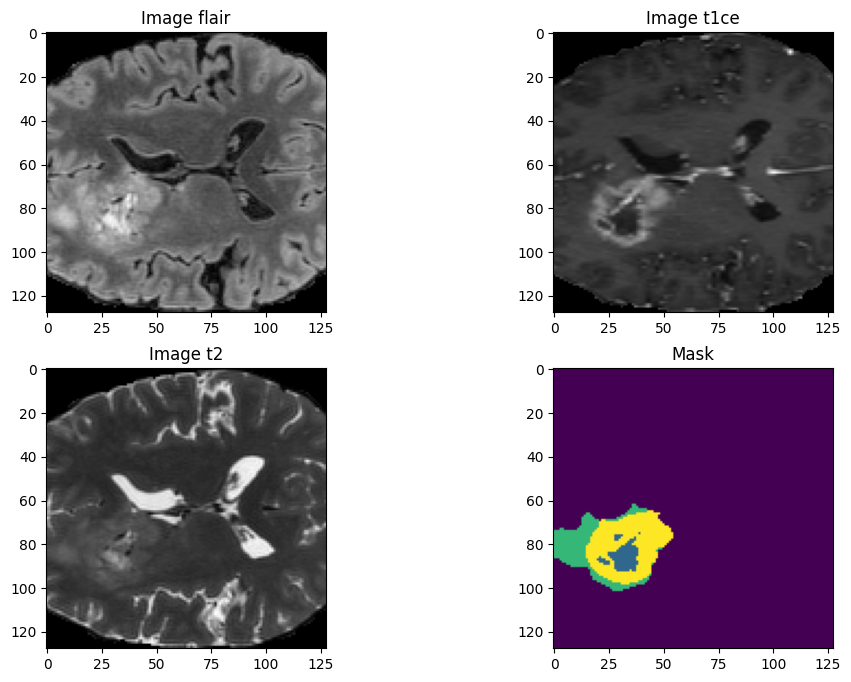

In [5]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' 


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs]) 
    model.summary()
    
    return model

 
model = simple_unet_model(128, 128, 64, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  1312        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 64  0           ['conv3d[0][0]']                 
                                , 16)                                                         

In [7]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [68]:
train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)


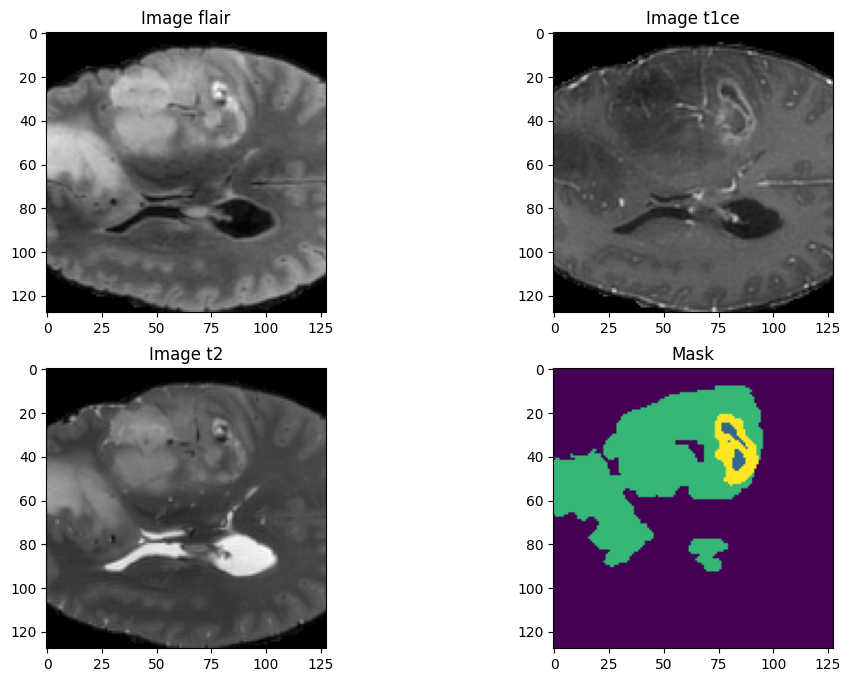

In [72]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [73]:
#Define the image generators for training and validation

train_img_dir = "Downloads/archive_2/input/output_data/train/images/"
train_mask_dir = "Downloads/archive_2/input/output_data/train/masks/"

val_img_dir = "Downloads/archive_2/input/output_data/val/images/"
val_mask_dir = "Downloads/archive_2/input/output_data/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [74]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


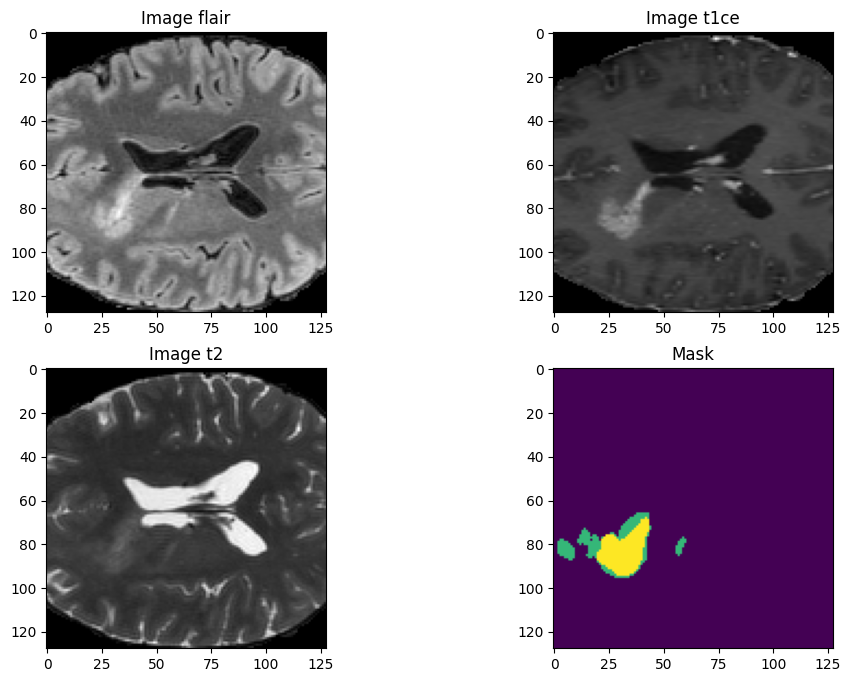

In [75]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [76]:
def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Dice coefficient for multi-class segmentation.
    y_true: Ground truth (batch_size, height, width, num_classes)
    y_pred: Predicted probabilities (batch_size, height, width, num_classes)
    smooth: Smoothing factor to avoid division by zero.
    """
    class_num = 4  # Fixed number of classes
    total_loss = 0.0

    for i in range(class_num):
        y_true_f = K.flatten(y_true[..., i])  # Flatten the ground truth for class i
        y_pred_f = K.flatten(y_pred[..., i])  # Flatten the predictions for class i
        intersection = K.sum(y_true_f * y_pred_f)  # Compute the intersection
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss

    return total_loss / class_num  # Return the average Dice coefficient

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [77]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
#
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [78]:
#Fit the model 
#import segmentation_models_3D as sm
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size




model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=64, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=metrics)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 64  1312        ['input_2[0][0]']                
                                , 16)                                                             
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 64  0           ['conv3d_19[0][0]']              
                                , 16)                                                       

In [79]:
from keras import backend as K


In [80]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=200,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )



Epoch 1/200
469/469 [==============================] - 373s 759ms/step - loss: 0.3097 - accuracy: 0.9147 - mean_io_u: 0.4209 - dice_coef: 0.2667 - precision: 0.9178 - sensitivity: 0.8813 - specificity: 0.9851 - val_loss: 0.1657 - val_accuracy: 0.9510 - val_mean_io_u: 0.3999 - val_dice_coef: 0.3096 - val_precision: 0.9668 - val_sensitivity: 0.9447 - val_specificity: 0.9892
Epoch 2/200
469/469 [==============================] - 356s 759ms/step - loss: 0.1509 - accuracy: 0.9582 - mean_io_u: 0.4571 - dice_coef: 0.3379 - precision: 0.9712 - sensitivity: 0.9449 - specificity: 0.9907 - val_loss: 0.1394 - val_accuracy: 0.9620 - val_mean_io_u: 0.3960 - val_dice_coef: 0.3470 - val_precision: 0.9736 - val_sensitivity: 0.9518 - val_specificity: 0.9914
Epoch 3/200
469/469 [==============================] - 356s 760ms/step - loss: 0.1282 - accuracy: 0.9628 - mean_io_u: 0.4560 - dice_coef: 0.3725 - precision: 0.9729 - sensitivity: 0.9543 - specificity: 0.9912 - val_loss: 0.1350 - val_accuracy: 0.9643

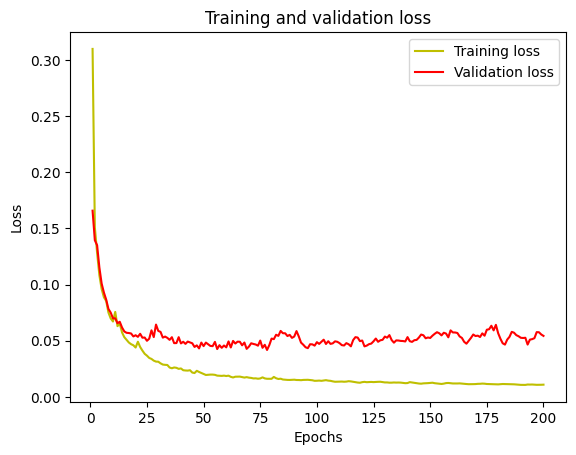

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

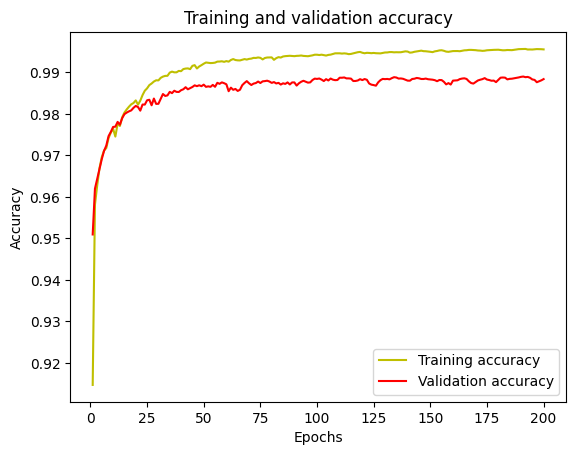

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

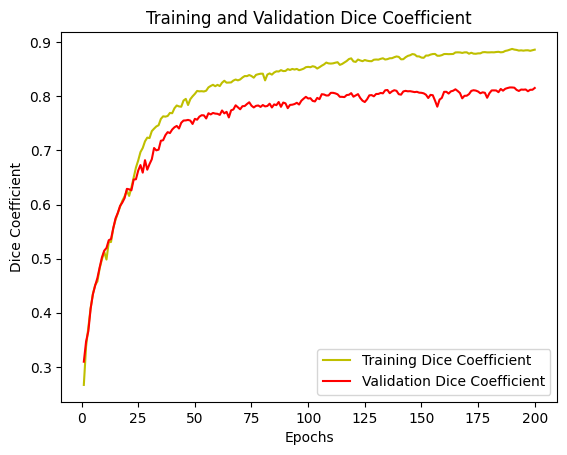

In [86]:
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


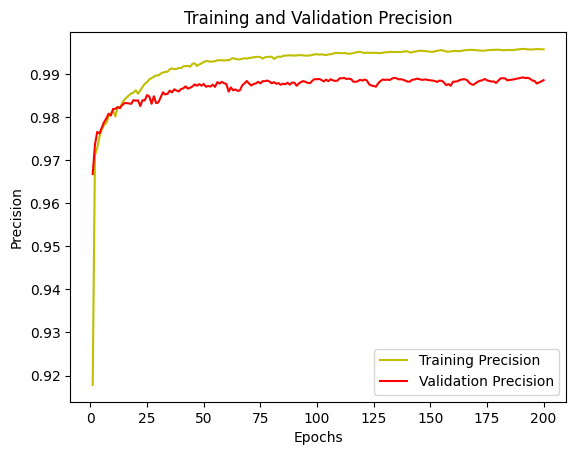

In [87]:
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, 'y', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()



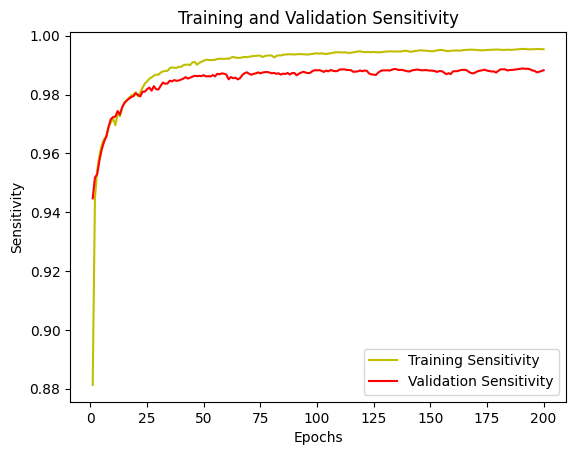

In [88]:
sensitivity = history.history['sensitivity']
val_sensitivity = history.history['val_sensitivity']
epochs = range(1, len(sensitivity) + 1)
plt.plot(epochs, sensitivity, 'y', label='Training Sensitivity')
plt.plot(epochs, val_sensitivity, 'r', label='Validation Sensitivity')
plt.title('Training and Validation Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()




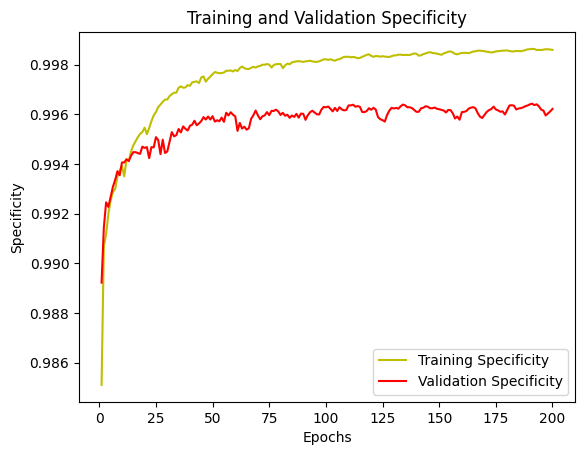

In [89]:
specificity = history.history['specificity']
val_specificity = history.history['val_specificity']
epochs = range(1, len(specificity) + 1)
plt.plot(epochs, specificity, 'y', label='Training Specificity')
plt.plot(epochs, val_specificity, 'r', label='Validation Specificity')
plt.title('Training and Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()
plt.show()





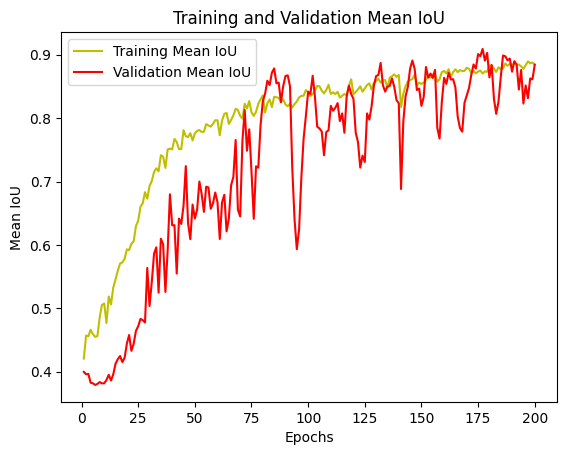

In [91]:
mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']
epochs = range(1, len(mean_iou) + 1)
plt.plot(epochs, mean_iou, 'y', label='Training Mean IoU')
plt.plot(epochs, val_mean_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()






In [18]:
import os
print(os.getcwd())


C:\Users\User


In [5]:
model.save('Downloads/archive_2/model_segmentation/brats_2021_200epoch.hdf5')


NameError: name 'model' is not defined

In [93]:
from keras.models import load_model
my_model = load_model('Downloads/archive_2/model_segmentation/brats_2021_200epoch.hdf5', compile = False)

In [94]:
#Prediction on a few test images, one at a time

img_num = 221

test_img = np.load("Downloads/archive_2/input/output_data/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("Downloads/archive_2/input/output_data/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 1s 639ms/step


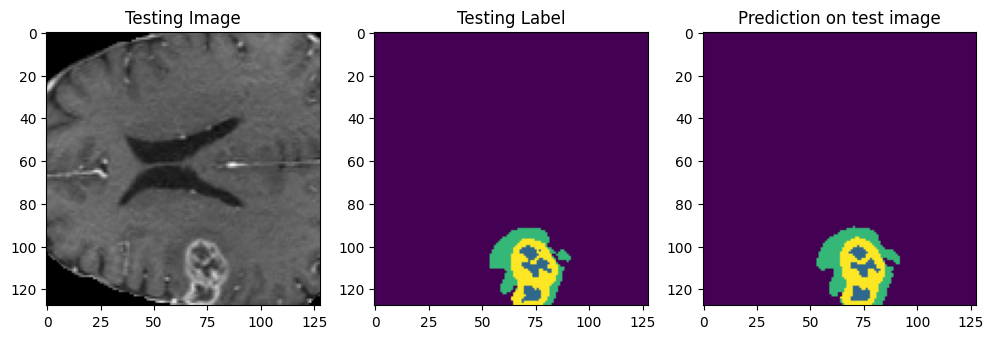

In [95]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 12
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [4]:
img_num = 222

test_img = np.load("Downloads/archive_2/input/output_data/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("Downloads/archive_2/input/output_data/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 12
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

NameError: name 'my_model' is not defined